In [1]:
import glob
import os
from random import shuffle
from nltk.tokenize import TreebankWordTokenizer
from gensim.models.keyedvectors import KeyedVectors
import numpy as np
from tensorflow import keras
word_vector=KeyedVectors.load_word2vec_format('data/GoogleNews-vectors-negative300.bin',binary=True)

def pre_process_data(filepath):
    positive_path=os.path.join(filepath,'pos')
    negative_path=os.path.join(filepath,'neg')
    pos_label=1
    neg_label=0
    dataset=[]
    for filename in glob.glob(os.path.join(positive_path,'*.txt')):
        dataset.append((pos_label,filename))
    for filename in glob.glob(os.path.join(negative_path,'*.txt')):
        dataset.append((neg_label,filename))
    shuffle(dataset)
    return dataset

dataset=pre_process_data('data/aclImdb/train')
split_point=int(len(dataset)*0.8)
trainData=dataset[:split_point]
testData=dataset[split_point:]
tokenizer=TreebankWordTokenizer()


trainlen=len(trainData)
testlen=len(testData)

def token_and_vectorize(filename,tokenizers):
    sample_vec=[]
    with open(filename,'r') as f:
        tokens=tokenizer.tokenize(f.read())
        for token in tokens:
            try:
                sample_vec.append(word_vector[token])
            except:
                pass
    return sample_vec

def pad_trunc(data,maxlen=400):
    zero_vector=[]
    for _ in range(len(data[0])):
        zero_vector.append(0.0)
    if len(data)>maxlen:
        temp=data[:maxlen]
    elif len(data)<maxlen:
        temp=data
        additional_elems=maxlen-len(data)
        for _ in range(additional_elems):
            temp.append(zero_vector)
    else:
        temp=data
    return temp

maxlen=206
batch_size=32
embedding_dims=300
epochs=10
dataset[:5]

[(1, 'data/aclImdb/train/pos/9383_8.txt'),
 (1, 'data/aclImdb/train/pos/8785_10.txt'),
 (1, 'data/aclImdb/train/pos/5790_7.txt'),
 (0, 'data/aclImdb/train/neg/2948_1.txt'),
 (0, 'data/aclImdb/train/neg/309_1.txt')]

In [2]:
def data_generator_second(data_store,tokenizers,batchsize=32,maxlen=400,embedding_dims=300):
    X,Y=[],[]
    while True:
        for i in range(len(data_store)):
            if (i % batchsize==0 and X and Y) or (i==len(data_store)):
                X=np.reshape(X,(len(X),maxlen,embedding_dims))
                Y=np.array(Y)
                yield X,Y
                X,Y=[],[]
            x,y=data_store[i][1],data_store[i][0]
            x=pad_trunc(token_and_vectorize(x,tokenizers),maxlen=maxlen)    
            X.append(x)
            Y.append(y)


In [3]:
import math
X_test=data_generator_second(testData,tokenizer,batchsize=batch_size,maxlen=maxlen)


In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Flatten,LSTM
num_neurons=50
model=Sequential()
model.add(LSTM(num_neurons,return_sequences=True,input_shape=(maxlen,embedding_dims)))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(1,activation='sigmoid'))
model.compile(optimizer='rmsprop',metrics=['accuracy'],loss='binary_crossentropy')
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 206, 50)           70200     
_________________________________________________________________
dropout (Dropout)            (None, 206, 50)           0         
_________________________________________________________________
flatten (Flatten)            (None, 10300)             0         
_________________________________________________________________
dense (Dense)                (None, 1)                 10301     
Total params: 80,501
Trainable params: 80,501
Non-trainable params: 0
_________________________________________________________________
None


In [5]:
import math
X_test=data_generator_second(testData,tokenizer,batchsize=batch_size,maxlen=maxlen)
history=model.fit_generator(data_generator_second(trainData,tokenizer,batchsize=batch_size,maxlen=maxlen),steps_per_epoch=math.ceil(trainlen/batch_size),epochs=10,validation_data=X_test,validation_steps=math.ceil(testlen/batch_size))

Epoch 1/10
625/625 [==============================] - 35s 53ms/step - loss: 0.5521 - accuracy: 0.7109 - val_loss: 0.3977 - val_accuracy: 0.8260
Epoch 2/10
625/625 [==============================] - 33s 53ms/step - loss: 0.3779 - accuracy: 0.8389 - val_loss: 0.3784 - val_accuracy: 0.8386
Epoch 3/10
625/625 [==============================] - 33s 54ms/step - loss: 0.3197 - accuracy: 0.8661 - val_loss: 0.3798 - val_accuracy: 0.8376
Epoch 4/10
625/625 [==============================] - 33s 53ms/step - loss: 0.2761 - accuracy: 0.8869 - val_loss: 0.3830 - val_accuracy: 0.8398
Epoch 5/10
625/625 [==============================] - 33s 53ms/step - loss: 0.2361 - accuracy: 0.9036 - val_loss: 0.4013 - val_accuracy: 0.8358
Epoch 6/10
625/625 [==============================] - 33s 53ms/step - loss: 0.1985 - accuracy: 0.9228 - val_loss: 0.4269 - val_accuracy: 0.8404
Epoch 7/10
625/625 [==============================] - 33s 53ms/step - loss: 0.1632 - accuracy: 0.9363 - val_loss: 0.4580 - val_accuracy:

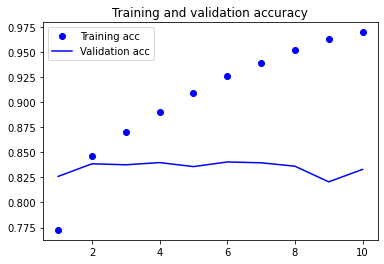

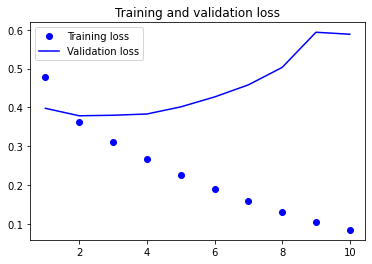

In [6]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']

val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.savefig("data/filename.png")
plt.show()

In [10]:
m_s=model.to_json()
with open('lstm_model.json','w') as json_file:
    json_file.write(m_s)
model.save_weights('lstm_weights.h5')

In [11]:
def token_and_vectorize_str(strString,tokenizers):
    sample_vec=[]
    tokens=tokenizer.tokenize(strString)
    for token in tokens:
        try:
            sample_vec.append(word_vector[token])
        except:
            pass
    return sample_vec
sample_1="I hate that the dismal weather had me down for so long,when will it break! Ugh, when does happiness return? The sun is blinding and the puffy clouds are too thin. I can't wait for the weekend."
test_vec=pad_trunc(token_and_vectorize_str(sample_1,tokenizer),maxlen=maxlen)
test_vec=np.reshape(test_vec,(1,400,300))

In [12]:
from tensorflow.keras.models import model_from_json
with open('lstm_model.json','r') as json_file:
    j_s=json_file.read()
modelX=model_from_json(j_s)
modelX.summary()
modelX.load_weights('lstm_weights.h5')
modelX.predict(test_vec)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 400, 50)           70200     
_________________________________________________________________
dropout (Dropout)            (None, 400, 50)           0         
_________________________________________________________________
flatten (Flatten)            (None, 20000)             0         
_________________________________________________________________
dense (Dense)                (None, 1)                 20001     
Total params: 90,201
Trainable params: 90,201
Non-trainable params: 0
_________________________________________________________________


array([[0.10526215]], dtype=float32)

In [13]:
modelX.predict_classes(test_vec)

array([[0]], dtype=int32)

In [14]:
model.predict(test_vec)

array([[0.10526215]], dtype=float32)

In [15]:
model.predict_classes(test_vec)

array([[0]], dtype=int32)

In [16]:
print("评价正负面分类,1-正面,2-负面:{}".format(model.predict_classes(test_vec)))

评价正负面分类,1-正面,2-负面:[[0]]


In [17]:
print("评价正负面分类,原始sigmoid的输出值:{}".format(model.predict(test_vec)))

评价正负面分类,原始sigmoid的输出值:[[0.10526215]]
